# Assignment 9

Neural need huge amount of data to be able to perform well. Huge amount of data means huge computation power... To bypass the fact that we don't own this kind of machine, we will us the transfer leaning. By using a pretrained network (usually on ImageNet) and train it a little bit, we can avoid most of the computationnal power needed to perform our task. We will work on the ResNet network (https://arxiv.org/pdf/1512.03385.pdf) designed in 2014. 
Then, because we know you all have a degree in medicine, we will try our luck bu doing some! We will then retrain the last layer of the network to be able to recognize leopard and cheetah. The cheetah mini database is in the image folder.

In [18]:
from __future__ import print_function, division
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests

plt.ion()   # interactive mode

In [19]:
data_dir = './images/cheetah_data_mini'
TRAIN = 'train'
TEST = 'val'

# ResNet Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
       # transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)
setLabels = image_datasets[TRAIN].classes

Loaded 450 images under train
Loaded 162 images under val
Classes: 
['cheetah', 'leopard', 'unknown']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


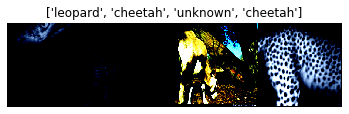

In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

## Pretrained network

Now load a network pre-trained on Imagenet and classify the validation data. You can import a pretrained model directly from pytorch with models.resnet18(pretrained=True). The labels are already used in ImageNet so try to recognize the database directly using the output of the pretrained network on the validation database.

In [21]:
#TO DO
def existingLabel(label):
    for i in image_datasets[TRAIN].classes:
        if(i in label):
            return True
    return False

LABELS_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json'
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

resnet = models.resnet18(pretrained=True)
resnet.eval()

def classifyData():
    for i in range(0,len(image_datasets['val'])):
        result2 = resnet(image_datasets['val'][i][0].unsqueeze(0)).data.numpy().argmax()
        print(labels[result2])
     
classifyData()


        #        print(image_datasets[TRAIN].classes[0])


megalith, megalithic structure
megalith, megalithic structure
megalith, megalithic structure
megalith, megalithic structure
megalith, megalithic structure
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
hog, pig, grunter, squealer, Sus scrofa
bluetick
armadillo
African crocodile, Nile crocodile, Crocodylus niloticus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
leopard, Panthera pardus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
armadillo
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
armadillo
armadillo
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jubatus
cheetah, chetah, Acinonyx jub

## Transfer learning

The pre-trained network can now be further trained with our data. Replace the last layer in the network with a fully connected Layer with 3 outputs for our classes cheetah, leopard and unknown. Then train the last layer of the network.

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

num_ftrs = resnet.fc.in_features

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(num_ftrs, 3)    

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

resnet = train_model(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)



Epoch 0/24
----------
train Loss: 0.8180 Acc: 0.6111
val Loss: 0.8007 Acc: 0.6235

Epoch 1/24
----------
train Loss: 0.6712 Acc: 0.7022
val Loss: 0.6860 Acc: 0.6790

Epoch 2/24
----------
train Loss: 0.5535 Acc: 0.7578
val Loss: 0.7508 Acc: 0.6914

Epoch 3/24
----------
train Loss: 0.5132 Acc: 0.7867
val Loss: 0.7300 Acc: 0.6790

Epoch 4/24
----------
train Loss: 0.5544 Acc: 0.7800
val Loss: 0.9342 Acc: 0.5864

Epoch 5/24
----------
train Loss: 0.5542 Acc: 0.7667
val Loss: 0.7861 Acc: 0.7469

Epoch 6/24
----------
train Loss: 0.5108 Acc: 0.7978
val Loss: 0.8082 Acc: 0.6914

Epoch 7/24
----------
train Loss: 0.4548 Acc: 0.8089
val Loss: 0.8723 Acc: 0.6481

Epoch 8/24
----------
train Loss: 0.4491 Acc: 0.8133
val Loss: 0.7922 Acc: 0.7346

Epoch 9/24
----------
train Loss: 0.3911 Acc: 0.8689
val Loss: 0.7711 Acc: 0.7222

Epoch 10/24
----------
train Loss: 0.4257 Acc: 0.8311
val Loss: 0.6666 Acc: 0.7284

Epoch 11/24
----------
train Loss: 0.4513 Acc: 0.8178
val Loss: 0.7103 Acc: 0.7346

Ep

Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: leopard , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: unknown , the correct output: 2
Algorithm output: leopard , the correct output: 2


In [25]:
## This classification is for the next part of the assignment
def classifyData2():
    for i in range(0,len(image_datasets['val'])):
        result2 = resnet(image_datasets['val'][i][0].unsqueeze(0)).data.numpy().argmax()
        print("Algorithm output: {} , the correct output: {}".format(setLabels[result2], setLabels[image_datasets['val'][i][1]]))
classifyData2()

Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: leopard , the correct output: cheetah
Algorithm output: leopard , the correct output: cheetah
Algorithm output: leopard , the correct output: cheetah
Algorithm output: leopard , the correct output: cheetah
Algorithm output: unknown , the correct output: cheetah
Algorithm output: cheetah , the correct output: cheetah
Algorithm output: cheetah , the correct output: cheetah
Algorithm output: cheetah , the correct output: cheetah
Algorithm output: cheetah , the correct output: cheetah
Algorithm output: cheetah , the correct output: 

Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
Algorithm output: unknown , the correct output: unknown
